In [1]:
%pylab inline

import zap_util as z
import statsmodels.api as sm
import statsmodels.formula.api as smf

z.set_style()
# Lista de modelos
rmse = {}


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = z.get('select * from vw_imovel')
numeric_columns = (df.dtypes[(df.dtypes==float64) | (df.dtypes==int64)]).index.tolist() + ['bairro_g']
df = df[numeric_columns]
df.columns


Index([u'area', u'preco', u'condominio', u'm2', u'garagem', u'quartos', u'suites', u'lat', u'lng', u'bairro_g'], dtype='object')

In [3]:
df.isnull().sum()

area              0
preco             0
condominio     6939
m2                0
garagem       11416
quartos           0
suites        21992
lat               0
lng               0
bairro_g          0
dtype: int64

In [4]:
df.fillna(0, inplace=True)
df.isnull().sum()

area          0
preco         0
condominio    0
m2            0
garagem       0
quartos       0
suites        0
lat           0
lng           0
bairro_g      0
dtype: int64

# Regressão apenas com latitude e longitude.

In [5]:

formula = 'df.preco ~ df.lat+ df.lng'
lm = sm.formula.ols(formula, df).fit()
rmse['lat e lng']= z.rmse(lm.resid)
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:               df.preco   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                 1.346e+04
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:04   Log-Likelihood:            -4.2572e+05
No. Observations:               53581   AIC:                         8.514e+05
Df Residuals:                   53578   BIC:                         8.515e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -7.075e+04   1700.368    -41.606      0.0

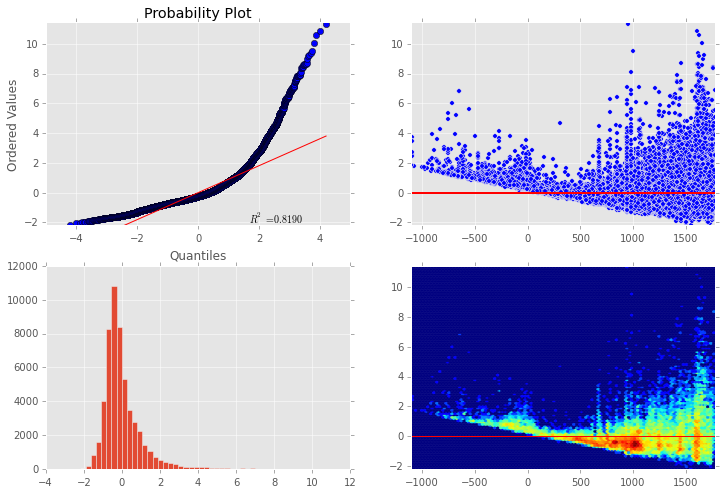

In [6]:
z.plot_residual(lm)

# Regressão com dados básicos dos anúncios.

In [7]:

formula = 'df.preco ~ df.area + df.condominio + df.garagem + df.quartos + df.suites+ df.lat+ df.lng'
lm = sm.formula.ols(formula, df).fit()
rmse['basico']= z.rmse(lm.resid)
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:               df.preco   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                 1.671e+04
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:06   Log-Likelihood:            -4.0560e+05
No. Observations:               53581   AIC:                         8.112e+05
Df Residuals:                   53573   BIC:                         8.113e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      1.418e+04   1322.540     10.724

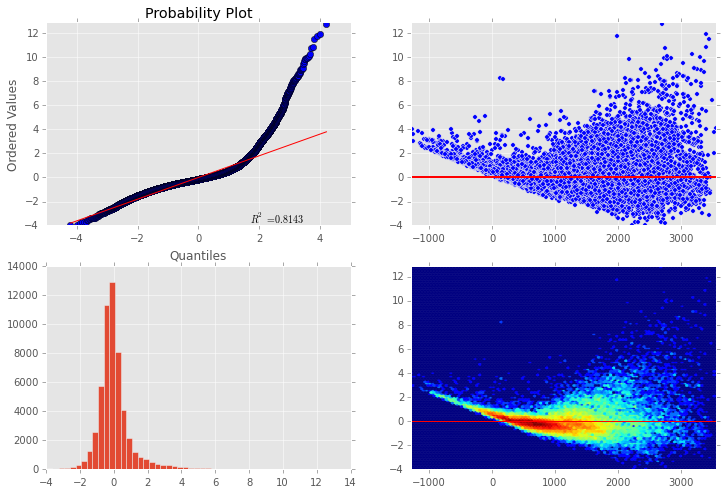

In [8]:
z.plot_residual(lm)


# Regressão com variáveis intrínsecas binárias.

In [9]:
dc = z.get('select * from _var_intrinseca')

# Adicionar prefixo "dm" para indicar variável dummy e remover espaços dos nomes.
dc.columns = ['dm_'+c.replace(' ','_') for c in dc.columns]

# Verificar validade das variáveis dummies. O valor máximo por coluna deve ser igual a 1.
m = dc.max(axis=0) 
m = m[m > 1].index.tolist()
col_excluded =  set(m)
for c in col_excluded:
    del dc[c]
m = dc.max(axis=0) 
m = m[m > 1].index.tolist()
m

[]

In [10]:
d = z.pd.concat([df,dc],1,'inner')


In [11]:
f = z.prep_formula(d,'d')[0]
f = f.replace('+ d.bairro_g','')
f

'd.preco  ~ d.dm_esquina + d.quartos + d.dm_closet + d.dm_sala_de_jantar + d.dm_armario + d.dm_recuado + d.dm_fundos + d.dm_andar_alto + d.dm_mezanino + d.dm_piscina + d.dm_playground + d.dm_hidrometro + d.lng + d.dm_seguranca + d.suites + d.area + d.dm_frente + d.dm_linear + d.dm_blindex + d.dm_terraco + d.dm_salao_de_jogos  + d.dm_children_care + d.dm_andar_inteiro + d.dm_churrasqueira + d.dm_dependencia + d.dm_estacionamento_visitantes + d.dm_banheira + d.dm_jardim + d.garagem + d.dm_duplex + d.dm_sol_da_tarde + d.condominio + d.lat + d.dm_varanda + d.dm_triplex + d.dm_sol_da_manha + d.dm_quarto_de_empregada + d.dm_lateral_ + d.dm_portaria + d.dm_indevassavel + d.dm_cobertura + d.dm_copa + d.dm_quadra + d.dm_sauna + d.dm_salao_de_festas + d.dm_andar_baixo + d.dm_elevador_privativo'

In [12]:
# Aplicar o modelo.
lm = sm.formula.ols(f, d).fit()
rmse['intrinseca']= z.rmse(lm.resid)
print(lm.summary())




                            OLS Regression Results                            
Dep. Variable:                d.preco   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     2580.
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:12   Log-Likelihood:            -4.0493e+05
No. Observations:               53581   AIC:                         8.099e+05
Df Residuals:                   53533   BIC:                         8.104e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

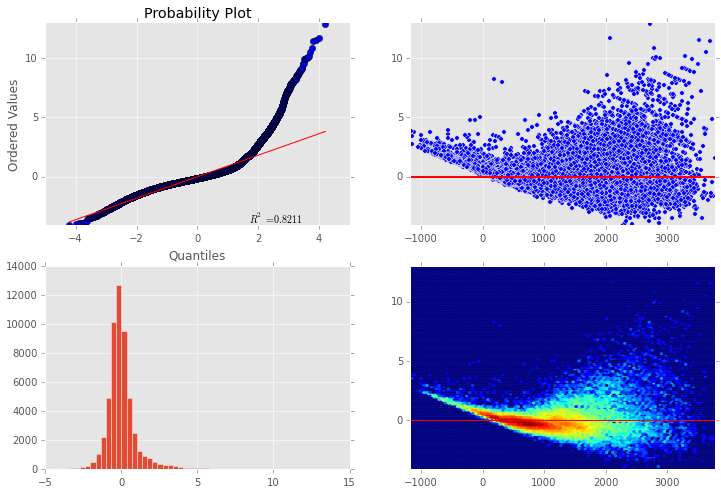

In [13]:
z.plot_residual(lm)

# Regressão com distâncias.

In [14]:
dd = z.get('select * from vw_distancia')
dd.describe()

,id_favela,dist_favela,id_bombeiro,dist_bombeiro,dist_centro,dist_centro_lng,dist_centro_lat,id_delegacia,dist_delegacia,id_lagoa,...,id_logradouro,dist_logradouro,id_metro,dist_metro,id_praia,dist_praia,dist_saude_publica,dist_saude_privada,id_trem,dist_trem
count,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,...,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000
mean,729.059069,0.614571,12.864784,1.654962,13.449490,11.045882,5.682883,14.140031,3.155151,2.317109,...,247.653553,0.291721,15.632948,6.858814,18.836397,3.600355,1.037211,0.324475,16.953118,6.680159
std,285.050084,0.602575,8.717148,1.211603,9.442173,10.050282,3.852094,12.388655,4.235173,1.892999,...,123.774518,0.442050,11.146833,7.911428,16.068283,3.445466,0.974125,0.349841,11.649281,4.738935
min,4.000000,0.000000,1.000000,0.007348,0.100943,0.000048,0.000438,1.000000,0.003547,1.000000,...,1.000000,0.000000,1.000000,0.008567,1.000000,0.000000,0.000000,0.000000,1.000000,0.003328
25%,394.000000,0.266550,6.000000,0.790498,6.313240,2.002879,2.173069,7.000000,0.703789,1.000000,...,172.000000,0.023365,5.000000,0.582056,4.000000,0.693509,0.374664,0.105035,8.000000,2.207006
50%,897.000000,0.456292,12.000000,1.260291,9.517048,7.399002,5.618187,11.000000,1.316363,1.000000,...,246.000000,0.155462,12.000000,2.450077,15.000000,2.117784,0.683850,0.226777,11.000000,6.341003
75%,947.000000,0.726724,17.000000,2.278280,19.973464,18.624556,8.578444,14.000000,3.408146,3.000000,...,311.000000,0.373339,28.000000,12.879695,30.000000,6.167344,1.316366,0.435816,23.000000,10.334973
max,1050.000000,6.077876,37.000000,9.115537,55.865946,55.821855,17.644322,54.000000,17.703650,7.000000,...,576.000000,6.536509,35.000000,39.019140,48.000000,22.218399,5.989452,7.596612,60.000000,17.702176


In [15]:
d = z.pd.concat([df,dc,dd],1,'inner')
d.describe()

,area,preco,condominio,m2,garagem,quartos,suites,lat,lng,dm_andar_alto,...,id_logradouro,dist_logradouro,id_metro,dist_metro,id_praia,dist_praia,dist_saude_publica,dist_saude_privada,id_trem,dist_trem
count,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,...,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000,53581.000000
mean,103.634497,1031.069850,0.602407,9.631854,1.111887,2.506056,0.755156,-22.949489,-43.284892,0.029973,...,247.653553,0.291721,15.632948,6.858814,18.836397,3.600355,1.037211,0.324475,16.953118,6.680159
std,52.191202,837.075602,0.440923,5.019605,0.807397,0.789575,0.795974,0.045462,0.098325,0.170515,...,123.774518,0.442050,11.146833,7.911428,16.068283,3.445466,0.974125,0.349841,11.649281,4.738935
min,16.000000,45.000000,0.000000,0.457746,0.000000,1.000000,0.000000,-23.066667,-43.721668,0.000000,...,1.000000,0.000000,1.000000,0.008567,1.000000,0.000000,0.000000,0.000000,1.000000,0.003328
25%,69.000000,470.000000,0.300000,5.948276,1.000000,2.000000,0.000000,-22.983534,-43.359094,0.000000,...,172.000000,0.023365,5.000000,0.582056,4.000000,0.693509,0.374664,0.105035,8.000000,2.207006
50%,89.000000,760.000000,0.540000,8.333333,1.000000,2.000000,1.000000,-22.951891,-43.249675,0.000000,...,246.000000,0.155462,12.000000,2.450077,15.000000,2.117784,0.683850,0.226777,11.000000,6.341003
75%,125.000000,1300.000000,0.850000,12.000000,2.000000,3.000000,1.000000,-22.920781,-43.197077,0.000000,...,311.000000,0.373339,28.000000,12.879695,30.000000,6.167344,1.316366,0.435816,23.000000,10.334973
max,300.000000,9000.000000,2.000000,30.000000,4.000000,4.000000,4.000000,-22.786389,-43.157761,1.000000,...,576.000000,6.536509,35.000000,39.019140,48.000000,22.218399,5.989452,7.596612,60.000000,17.702176


In [16]:
f = z.prep_formula(d,'d')[0]
f = f.replace('+ d.bairro_g','')

In [17]:

# Executar o modelo.
lm = sm.formula.ols(f, d).fit()
rmse['distancia']= z.rmse(lm.resid)
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:                d.preco   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     2673.
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:19   Log-Likelihood:            -3.9950e+05
No. Observations:               53581   AIC:                         7.991e+05
Df Residuals:                   53520   BIC:                         7.997e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

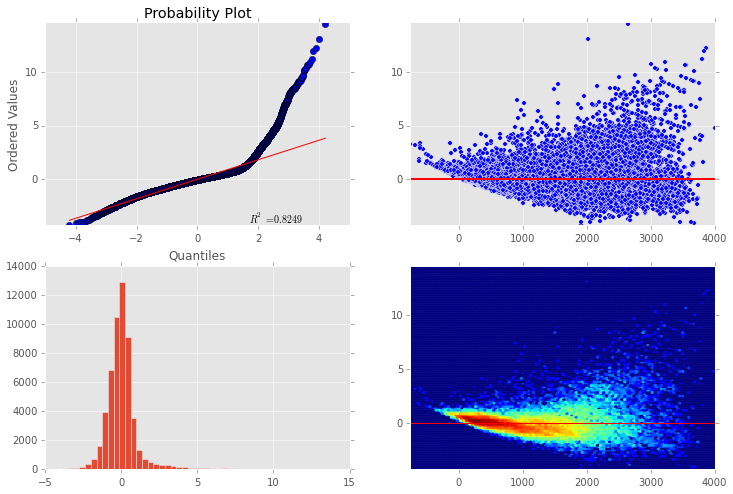

In [18]:
z.plot_residual(lm)

## Realizar regressão com todos os dados, incluindo bairros.

In [19]:
f = z.prep_formula(d,'d')[0]

In [20]:
# Executar o modelo.
lm = sm.formula.ols(f, d).fit()
rmse['bairros_dummies']= z.rmse(lm.resid)
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:                d.preco   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1045.
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:24   Log-Likelihood:            -3.9250e+05
No. Observations:               53581   AIC:                         7.854e+05
Df Residuals:                   53366   BIC:                         7.874e+05
Df Model:                         214                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------

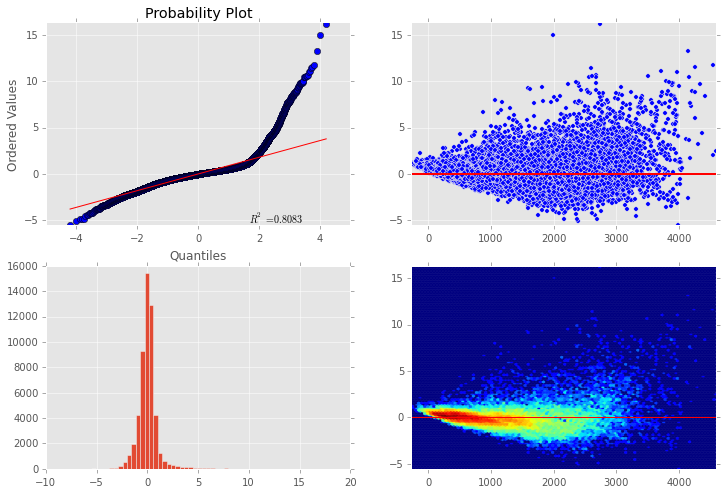

In [21]:
z.plot_residual(lm)

# Incluir variáveis socioeconômicas.

In [22]:
dv = z.get('select b.id, v.* from _var_socioecon v inner '+
           ' join vw_imovel_bairro b on b.id_bairro_g = v.gid ')

del dv['gid'], dv['nome']


In [23]:
# Construir dataset.
d = z.pd.concat([df,dc,dd,dv],1,'inner' )

# Executar o modelo.
lm = sm.formula.ols(z.prep_formula(d,'d')[0], d).fit()
rmse['vizinhanca']= z.rmse(lm.resid)
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                d.preco   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1045.
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:30   Log-Likelihood:            -3.9250e+05
No. Observations:               53581   AIC:                         7.854e+05
Df Residuals:                   53366   BIC:                         7.874e+05
Df Model:                         214                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------

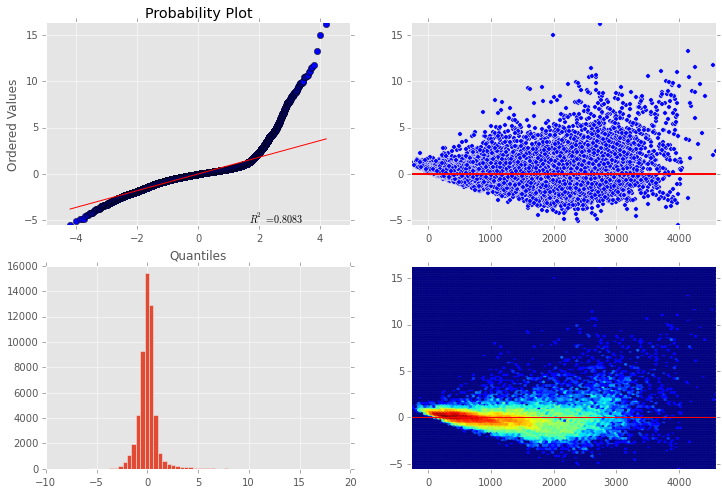

In [24]:
z.plot_residual(lm)

# Todos os dados, incluindo conversão de variáveis categóricas numéricas em dummies.

In [25]:
f = z.prep_formula(d,'d')[0]
f = f.replace('d.garagem', 'C(d.garagem)')
f = f.replace('d.quartos', 'C(d.quartos)')
f = f.replace('d.suites', 'C(d.suites)')


# Construir dataset.
d = z.pd.concat([df,dc,dd,dv],1,'inner' )

# Executar o modelo.
lm = sm.formula.ols(f, d).fit()
rmse['completo']= z.rmse(lm.resid)
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                d.preco   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     1016.
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:36   Log-Likelihood:            -3.9231e+05
No. Observations:               53581   AIC:                         7.851e+05
Df Residuals:                   53358   BIC:                         7.870e+05
Df Model:                         222                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------

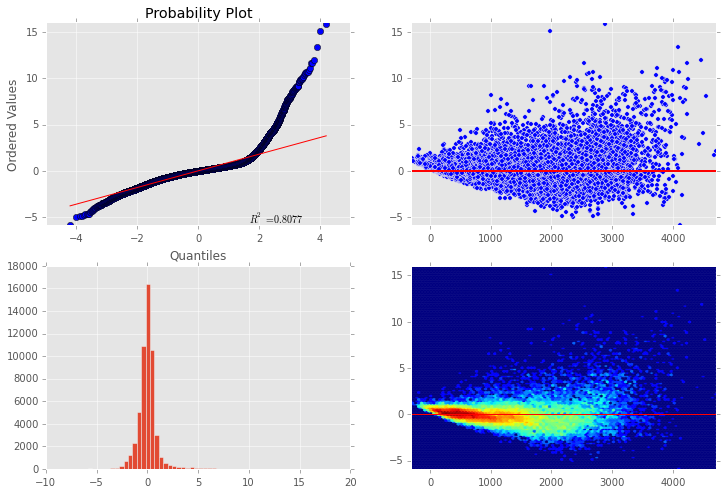

In [26]:
z.plot_residual(lm)

# Regressão em um conjunto menor de dados, como o bairro Tijuca

In [27]:


dbairro = d[d.bairro_g == 'Tijuca'].copy()
lm = sm.formula.ols(z.prep_formula(dbairro,'dbairro')[0], dbairro).fit()
rmse['completo, tijuca']= z.rmse(lm.resid)
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:          dbairro.preco   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     186.1
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:37   Log-Likelihood:                -26376.
No. Observations:                4019   AIC:                         5.287e+04
Df Residuals:                    3960   BIC:                         5.324e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------


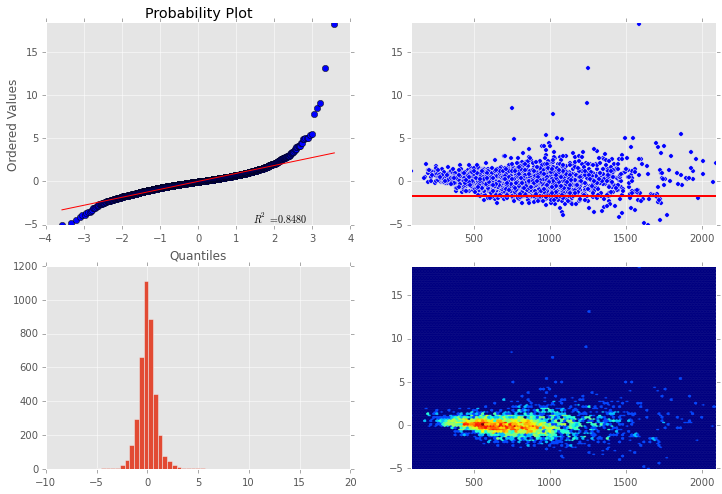

In [28]:

z.plot_residual(lm)


# Regressão em um conjunto menor de dados, como o bairro Copacabana.

In [29]:


dbairro = d[d.bairro_g == 'Copacabana'].copy()
lm = sm.formula.ols(z.prep_formula(dbairro,'dbairro')[0], dbairro).fit()
rmse['completo, copacabana']= z.rmse(lm.resid)
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:          dbairro.preco   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     312.7
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:39   Log-Likelihood:                -40901.
No. Observations:                5531   AIC:                         8.192e+04
Df Residuals:                    5470   BIC:                         8.233e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------


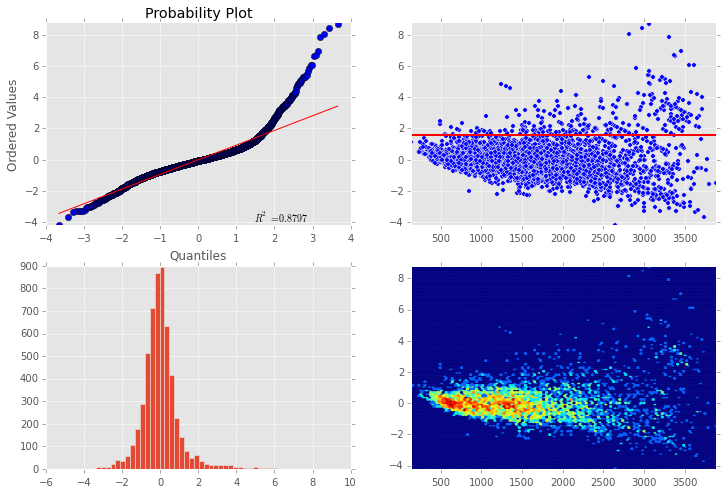

In [30]:
z.plot_residual(lm)

# Regressão em um conjunto menor de dados, como o bairro Engenho Novo.

In [31]:

dbairro = d[d.bairro_g == 'Engenho Novo'].copy()
lm = sm.formula.ols(z.prep_formula(dbairro,'dbairro')[0], dbairro).fit()
rmse['completo, engenho novo']= z.rmse(lm.resid)
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:          dbairro.preco   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     4.224
Date:                Sat, 04 Apr 2015   Prob (F-statistic):           1.09e-15
Time:                        16:18:40   Log-Likelihood:                -1992.6
No. Observations:                 367   AIC:                             4089.
Df Residuals:                     315   BIC:                             4292.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------


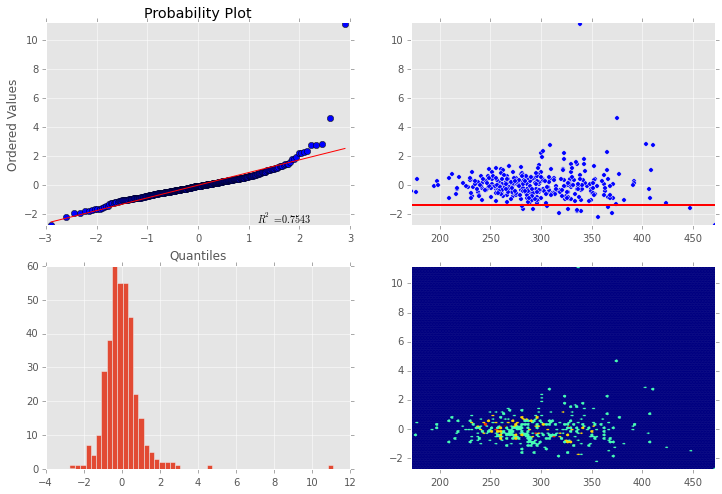

In [32]:
z.plot_residual(lm)

# Análise das Correlações.

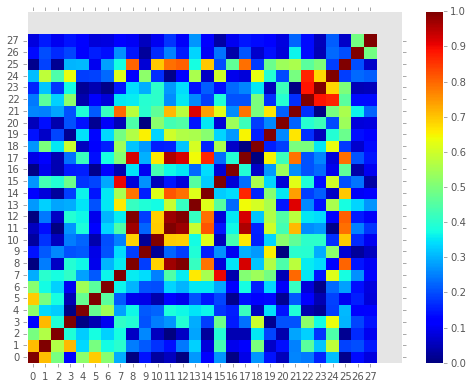

In [33]:
# Caractarísticas dummies não são adequadas par correlações.
d = z.pd.concat([df,dd,dv],1,'inner')



# Selecionar colunas que não são identificadores.
valid_cols = [c for c in d.columns if c.find('id')==-1];

 
corrMatrix=d[valid_cols].corr();
z.plot_corrmatrix(abs(corrMatrix),cmap=None)


In [34]:
# Lista das melhores correlações
# http://stackoverflow.com/questions/24002820/returning-groups-of-correlated-columns-in-pandas-data-frame        

corr_threshold = 0.69999

corrMatrix2 = corrMatrix.copy()
corrMatrix2.loc[:,:] =  tril(corrMatrix, k=-1) # borrowed from Karl D's answer

already_in = set()
result = []
for col in corrMatrix2:
    perfect_corr = corrMatrix2[col][abs(corrMatrix2[col]) > corr_threshold].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result.append(perfect_corr)

print (result)

[['preco', 'area'], ['dist_lagoa', 'dist_trem', 'lat'], ['dist_centro', 'dist_centro_lng', 'dist_delegacia', 'dist_metro', 'se_saneamento', 'lng'], ['dist_trem', 'dist_centro_lat'], ['se_perc_alfabetizacao', 'se_renda', 'se_anos_estudo']]


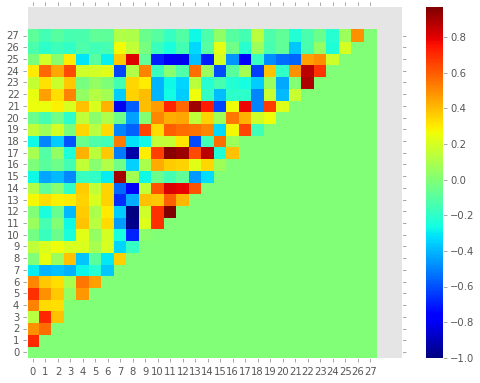

In [35]:
z.plot_corrmatrix(tril(corrMatrix, k=-1))

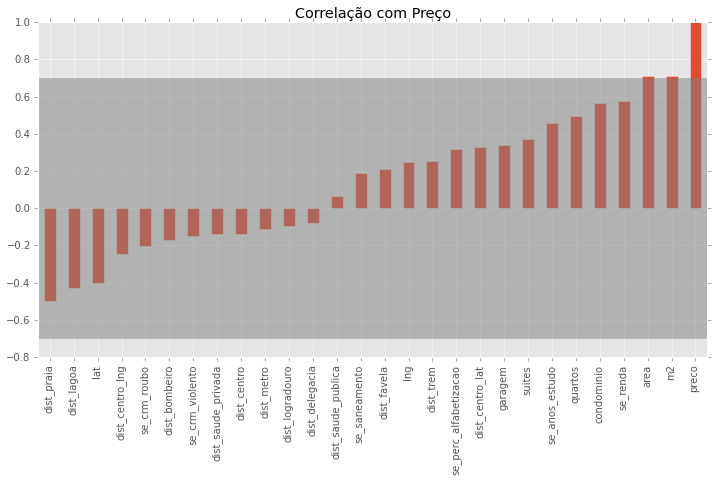

In [36]:
corrpreco = corrMatrix['preco'].copy()
corrpreco.sort()
corrpreco.plot(kind='bar', figsize=(12,6));
title(u'Correlação com Preço');
axhspan(-corr_threshold, corr_threshold, alpha=0.5, color='grey')

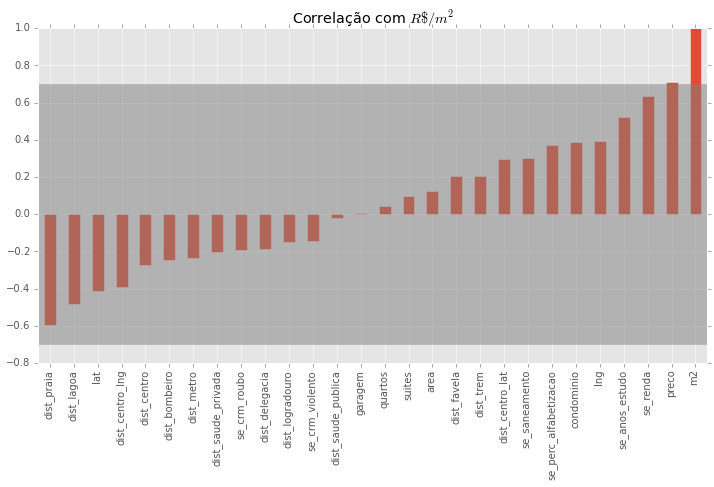

In [37]:
corrpreco = corrMatrix['m2'].copy()
corrpreco.sort()
corrpreco.plot(kind='bar', figsize=(12,6));
title(u'Correlação com $R\$/m^2$');
axhspan(-corr_threshold, corr_threshold, alpha=0.5, color='grey');

# Encontrar características autocorrelacionadas.

In [38]:
reload(z)
d = z.pd.concat([df,dc,dd,dv],1,'inner')
    
# Excluir colunas que  são identificadores e variáveis dependentes.
cols_excluded = set([c for c in d.columns if c.find('id_')==0])
cols_excluded = cols_excluded.union(set(['preco','m2']))

z.print_autocorr(d,cols_excluded)







Coluna               | Autocorrelacionada com                            
se_anos_estudo       : ['se_renda(0.87)', 'se_perc_alfabetizacao(0.89)'] 
dist_delegacia       : ['dist_centro(0.82)', 'dist_centro_lng(0.79)', 'dist_metro(0.87)']
dist_centro_lng      : ['se_saneamento(-0.80)', 'dist_metro(0.92)']      
dm_piscina           : ['dm_churrasqueira(0.70)', 'dm_sauna(0.73)']      
se_saneamento        : ['dist_metro(-0.79)']                             
se_idh               : ['se_anos_estudo(0.95)', 'se_renda(0.77)', 'se_perc_alfabetizacao(0.89)']
dist_centro          : ['dist_centro_lng(0.97)', 'se_saneamento(-0.79)', 'dist_metro(0.96)']
lng                  : ['dist_delegacia(-0.79)', 'dist_centro(-0.97)', 'dist_centro_lng(-1.00)', 'se_saneamento(0.80)', 'dist_metro(-0.92)']
dist_trem            : ['dist_delegacia(0.74)', 'lat(-0.80)', 'dist_centro_lat(0.91)', 'dist_centro(0.71)', 'dist_metro(0.79)']
dist_lagoa           : ['lat(0.91)']                                     


# Remover colunas autocorrelacionadas e tentar novamente.

In [39]:
# Atualizar coluna a ser excluída do modelo.
cols_excluded = cols_excluded.union(['dm_suites_0','dm_quartos_0',
    'dm_garagem_0', 'b_Centro', 'dm_lareira','dist_delegacia',
    'dm_sauna','dist_centro_lat','dist_lagoa','dist_metro'])

z.print_autocorr(d,cols_excluded)


Coluna               | Autocorrelacionada com                            
se_anos_estudo       : ['se_renda(0.87)', 'se_perc_alfabetizacao(0.89)'] 
dist_centro_lng      : ['se_saneamento(-0.80)']                          
dm_piscina           : ['dm_churrasqueira(0.70)']                        
lng                  : ['dist_centro(-0.97)', 'dist_centro_lng(-1.00)', 'se_saneamento(0.80)']
dist_centro          : ['dist_centro_lng(0.97)', 'se_saneamento(-0.79)'] 
se_idh               : ['se_anos_estudo(0.95)', 'se_renda(0.77)', 'se_perc_alfabetizacao(0.89)']
dist_trem            : ['lat(-0.80)', 'dist_centro(0.71)']               


In [40]:
# Atualizar coluna a ser excluída do modelo.
cols_excluded = cols_excluded.union(['dist_saude_publica','dist_centro_lng','dist_trem','dist_centro','dm_churrasqueira'])

z.print_autocorr(d,cols_excluded)


Coluna               | Autocorrelacionada com                            
lng                  : ['se_saneamento(0.80)']                           
se_anos_estudo       : ['se_renda(0.87)', 'se_perc_alfabetizacao(0.89)'] 
se_idh               : ['se_anos_estudo(0.95)', 'se_renda(0.77)', 'se_perc_alfabetizacao(0.89)']


# Repetir modelo completo excluindo as colunas auto correlacionadas.

In [41]:
# Atualizar coluna a ser excluída do modelo.
valid_cols = list(set(d.columns.tolist())-cols_excluded)

z.print_autocorr(d[valid_cols])


Coluna               | Autocorrelacionada com                            
lng                  : ['se_saneamento(0.80)']                           
se_anos_estudo       : ['se_renda(0.87)', 'se_perc_alfabetizacao(0.89)'] 
se_idh               : ['se_anos_estudo(0.95)', 'se_renda(0.77)', 'se_perc_alfabetizacao(0.89)']


In [42]:
# Executar o modelo.
d2 = d[valid_cols+['preco']]
lm = sm.formula.ols(z.prep_formula(d2,'d2')[0], d2).fit()
rmse['completo, sem autocorr ']= z.rmse(lm.resid)
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:               d2.preco   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     1084.
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:18:49   Log-Likelihood:            -3.9275e+05
No. Observations:               53581   AIC:                         7.859e+05
Df Residuals:                   53376   BIC:                         7.877e+05
Df Model:                         204                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------

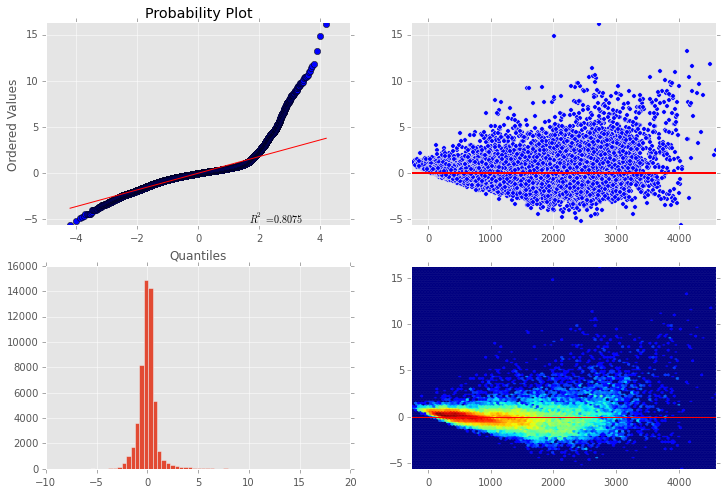

In [43]:
z.plot_residual(lm)

Vemos que os muitos p-value > 0.05, constando que $H_0 : mean(X_i) = 0$ não pode ser refutada.

# Determinar se a Regresssão ou média simples é o melhor método.

In [46]:
modelo_rl = z.rmse(lm.resid)
modelo_media = z.rmse(d.preco-d.preco.mean())
if modelo_rl < modelo_media :
    print 'REGRESSAO WINS por {:.2f}%'.format((1-modelo_rl/modelo_media)*100)
else:
    print 'MEDIA WINS por {:.2f}%'.format((1-modelo_media/modelo_ml)*100)

REGRESSAO WINS por 55.91%


In [47]:
 modelo_rl , modelo_media

(369.08270612855961, 837.06779051662772)

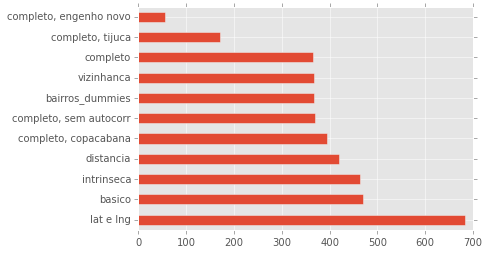

In [48]:
srmse = z.pd.Series(data=rmse.values(),index=rmse.keys())
srmse.sort(ascending=False)
srmse.plot(kind='barh');